In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Importing all necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt

### Our images have 300 x 300 pixels so our model would be the same size.

## Otherwise, you get an error.

IMG_SIZE = (300, 300)
nb_train_samples =400
nb_validation_samples = 100

epochs = 5
batch_size = 10


In [3]:
## -----------------
## Important !!!!

##You can handle any dataset in any way so this makes your project unique.
## We will see the differences from original projects at later.
## By the way,our dataset is not cats vs dogs,it is horses vs humans. 
## 

## -----------
train_data_dir = 'C:/Users/Monster/Desktop/horse-or-human/train'
validation_data_dir = 'C:/Users/Monster/Desktop/horse-or-human/validation'


train_dataset = image_dataset_from_directory(train_data_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_data_dir,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  image_size=IMG_SIZE)

Found 1028 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


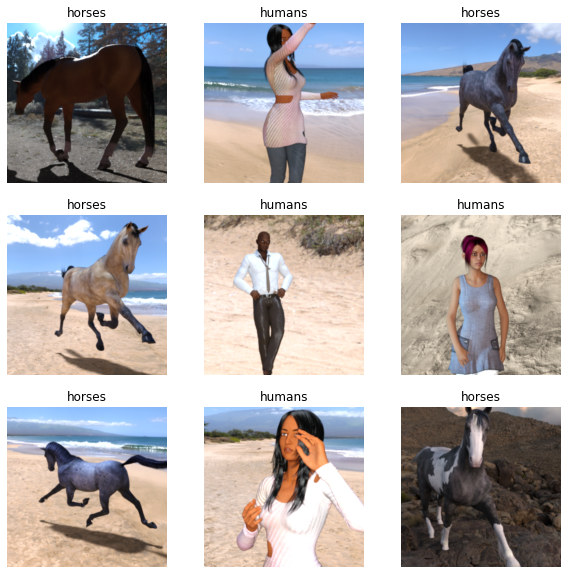

In [4]:
##Just shown labels and images.

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

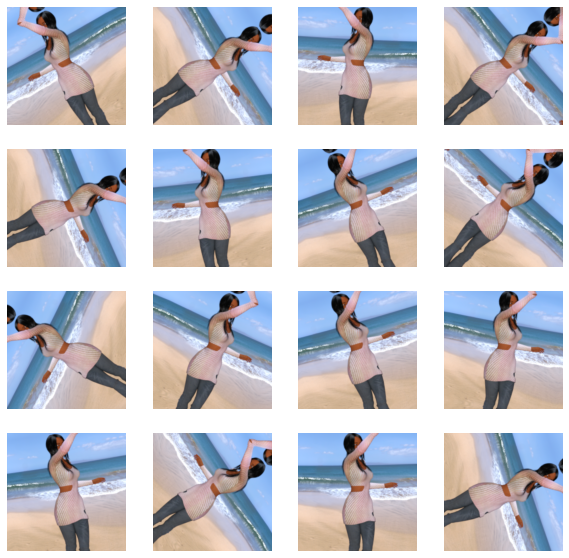

In [6]:
##This part shows that we did something visual which is called data augmentation.
##Data augmentation means rotating images in degrees. 
##Also,you can select vertical rotating if you want.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[5]
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [7]:
##Computing the number of batches for validation set and test dataset.

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
##Scaling objects for our purpose 

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(10, 10, 10, 1280)


In [14]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [15]:
##We use average pooling layer for purpose.
##At this layer,we perform classification.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


In [17]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

##This part contains lots of thing.As you see,we used mobilenetv2 and we added some layers.This is called 'transfer learning'.With this operation,
## we have 8 layers in total.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 300, 300, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 300, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [19]:
##We all know that what learning rate, Adam and BinaryCrossEntropy are

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
initial_epochs = 1

loss0, accuracy0 = model.evaluate(validation_dataset)

21/21 [==============================] - 9s 360ms/step - loss: 0.5792 - accuracy: 0.5243


In [21]:
## Model.fit function starts to training and it is assigned to history variable for later use.

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

##We get %90 accuracy for first epoch.My aim is to show it works. You can increase the number of epochs.

103/103 [==============================] - 156s 1s/step - loss: 0.0762 - accuracy: 0.9689 - val_loss: 0.0149 - val_accuracy: 1.0000


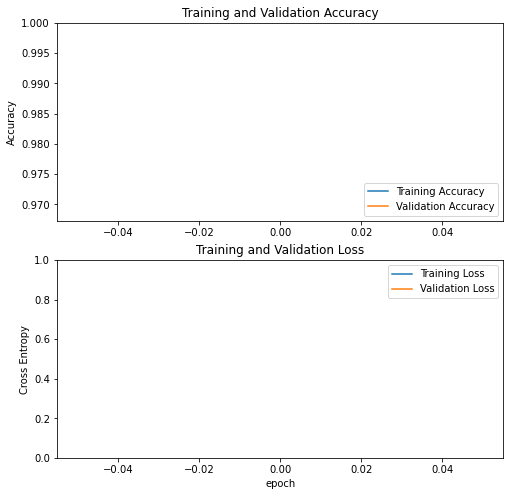

In [22]:
#If you want to see something visual,you can write down this code.
## We just trained 1 epoch so it does not draw anything.
## If you train more,graph will start to drawing.
##We save some values to history variable and plotting them in matplotlib according to their layer.



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
## Fine Tuning 

## This means you can continue to training by unfreezing base model.
model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5


##----------------------------------------------
## Important !!!!

# We have 8 layers in total so we can select smaller number for fine tuning.
##If we were not careful,we can say it does not work but if you know what you did,you can see the real thing :)

## ----------------------------------------------

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

## We select a layer that is started to train. Earlier layers remains freezed.

## As always , we compile model before training / testing 
## We assigned methods and parameters for model so it is the same thing.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

Number of layers in the base model:  8


C:\Users\Monster\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
## When you make any changes on your model,you can type 'summary to see what happens to your model.
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 300, 300, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 300, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [25]:
len(model.trainable_variables)

2

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
## At this stage,we show that how fine tuning is done. 
##If you unfreeze some layers for traning, this means you can continue training where you set.Earlier layers remains freezed and weights does not change.
##For unfreezed layers,weights changes continuously.


fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 1/4
103/103 [==============================] - 56s 522ms/step - loss: 9.0897e-04 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9951
Epoch 2/4
 27/103 [======>.......................] - ETA: 28s - loss: 0.0090 - accuracy: 0.9963

KeyboardInterrupt: 

In [28]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 2s 361ms/step - loss: 0.0128 - accuracy: 1.0000
Test accuracy : 1.0


Tahmin:
 [0 1 1 1 0 1 1 1 1 1]
Sınıfı:
 [0 1 1 1 0 1 1 1 1 1]


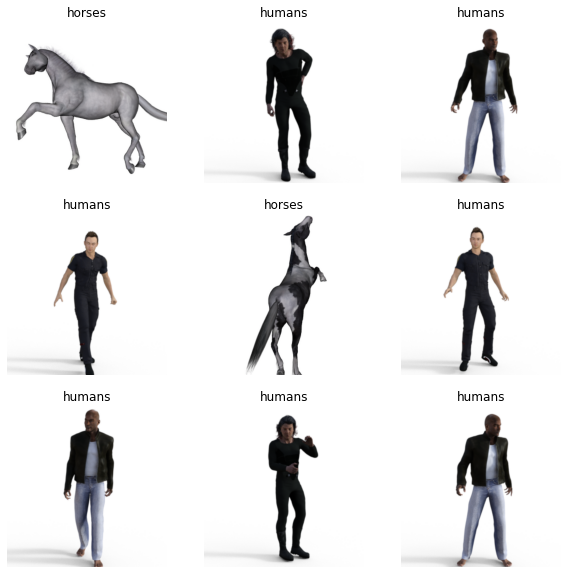

In [30]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

##Here,humans are 1 and horses are 0.Also you can make it vice versa.
## You can show as many as you want.

print('Tahmin:\n', predictions.numpy())
print('Sınıfı:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [31]:
##Finally, we save the model.

model.save('fine.h5')

C:\Users\Monster\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
